# the structure of hippocampal CA1 interactions optimizes spatial coding across experience
Michele Nardin, Jozsef Csicsvari, Gašper Tkačik, Cristina Savin 

https://doi.org/10.1101/2021.09.28.460602

This is the code used to generate synthetic CA1 place cells data with known connectivity structure.


To validate our method, we construct an artificial dataset with know interactions, by sampling from a coupled stimulus dependent MaxEnt model. We consider $N=50$ neurons and binary activations $\vec{y} = (y_1, \dots y_N)^T$ for any given time window. The distribution of responses $\vec{y}$ given a location-stimulus $s$ and synchrony level $k$ is
\begin{equation}
    p(\vec{y} | s,k) \propto \exp \left( \sum_i f_i(s) y_i + \sum_{i>j} W_{ij} y_i y_j - h_0(k)\sum_i y_i \right)
\end{equation} 
 where  $s \in \{ s_1, \dots, s_K \}$ is a spatial position chosen from a set of discrete locations uniformly spaced in the environment, and the feedforward input to each cell, $f_i = f_i(s)$, which represents an idealized place cell input.
We try to match the general statistics of the data as closely as possible. In particular, we match the true time-dependent occupancy, $s_t$, observed in a 20 minutes exploration session, and the corresponding time-dependent synchrony observed in the same session, $k_t$, by sampling one population activity vector (after adequate burn-in time) at each time point $\vec{y}(t) \sim P(\vec{y} | s_t, k_t)$ using Gibbs sampling

### setup

In [48]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import libr.ising as isi
import libr.gaubc as bc
import scipy.stats as stat

In [2]:
# plotting preferences
import matplotlib
matplotlib.rcParams['font.size']=16

In [4]:
### useful scripts ###
# Gibbs sampling
def prop(sigma, # current sample
         k, # proposed index
         h, # input strength
         J, # connection strength
         h0, # h0 param
         fk, # spatial tuning
         C): # correlation matrix
    sign = -np.sign(sigma[k]-0.5)
    return np.exp(sign*(h*fk + J*(C[k]@sigma) - h0))

# squared distance to a point - continuous boundary
def dist_cent(C,cent):
    dis=[]
    a = np.arange(C)
    b=np.arange(-C,0)
    c=np.arange(C)+C
    for co1,co2 in [[a,a],[a,b],[a,c],[b,a],[b,b],[b,c],[c,a],[c,b],[c,c]]:
        x_c = np.meshgrid((co1+0.5)/C,
                (co2+0.5)/C,
                indexing='ij')
        x_l = np.array(x_c).reshape(2,-1).T
        dis.append(np.sum((x_l - cent)**2,1))
    return np.min(dis,0)

# gaussian place field with continuous boundary
def gaussbc(C,cent,sigma=0.1):
    y = dist_cent(C,cent)/sigma
    return np.exp(-y)

Parameters

In [17]:
# use a connectivity similar to novel / familiar
B = 20 # number of bins
N = 50 # number of cells
Ek = 5 # expected number of spikes per sample
sig = 0.1 # size of place field
h=3 # input strength - somewhat intermediate beween familiar and novel

In [18]:
# indexes
x_B = np.meshgrid(np.arange(B)+0.5,
            np.arange(B)+0.5,
            indexing='ij')
i_B = np.unravel_index(np.arange(B*B),[B,B])
x_l = np.array(x_B).reshape(2,-1).T
i_l = np.ravel_multi_index(np.meshgrid(range(B),range(B),indexing='ij'),[B,B])
Nxy = len(x_l)

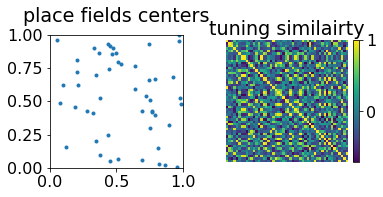

In [19]:
# cell tuning
np.random.seed(52) # set seed for reproducibility
cent = np.random.rand(2*N).reshape(-1, 2) # random centers
# gaussian and tuning similarity
f = tuning = np.array([gaussbc(B,cent[cell],sig) for cell in range(N)])
tunsim = np.corrcoef(tuning)

# plot centers
ax = plt.subplot(121,aspect='equal')
plt.plot(cent[:,0],cent[:,1],'.')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('place fields centers',y=1.05)

# plot tuning similarity
ax = plt.subplot(122,aspect='equal')
plt.imshow(tunsim)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('tuning similairty')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'connection')

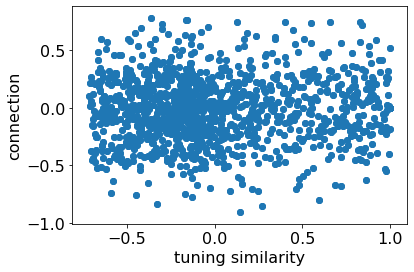

In [68]:
# random connectivity
np.random.seed(12)
C_ran = np.random.randn(tunsim.shape[0],tunsim.shape[1])
# make it symmetric
C_ran = (C_ran + C_ran.T) / 5
C_ran[np.diag_indices(N)]=0
plt.scatter(tunsim,C_ran)

np.corrcoef(C_ran.flatten(),tunsim.flatten())
plt.xlabel('tuning similarity')
plt.ylabel('connection')

Here we find the parameters h0(k) that keep the average firing as close to k as possible

In [82]:
pos_h0s = np.arange(45)/10
steps=60
mfr = []
for h0 in pos_h0s:
    print('*',end='')

    mf=0
    # initial random
    current = (np.random.rand(N) > (N - Ek)/N)

    for x in range(Nxy): # position
        ra = np.random.rand(N,steps) # sample random numbers
        samps = []
        for i in range(steps):
            for k in range(N):
                if prop(current,k,h,1,h0,f[k,x],C_ran) >= ra[k,i]:
                    current[k] = not current[k]
            if i > 10: # burn-in: corresponds to 500 flips
                samps.append(current.copy())
        mf += np.mean(np.sum(samps,1))
    mfr.append(mf/Nxy)
mfrs.append(mfr)

*********************************************

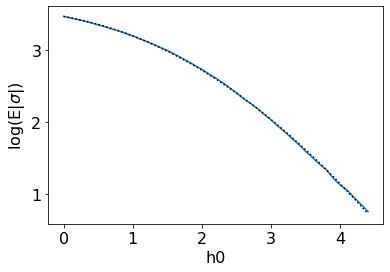

In [104]:
# plot the relation - fit a second order polynomial
plt.plot(pos_h0s,np.log(mfr))
# fit exponential
z=np.polyfit(pos_h0s, np.log(mfr), 2)
p=np.poly1d(z)
plt.plot(pos_h0s,p(pos_h0s),color='k',linestyle='dotted')
plt.xlabel('h0')
plt.ylabel('log(E|$\sigma$|)')
plt.show()

In [105]:
h0_k = [(p-np.log(k)).roots for k in range(1,30)]

Text(0, 0.5, 'h0')

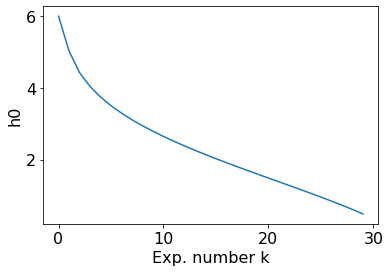

In [121]:
h0_nk = [6]+[r[np.isreal(r)][-1] for r in h0_k]
plt.plot(h0_nk)
plt.xlabel('Exp. number k')
plt.ylabel('h0')

In [42]:
# % of cells active in a real data exploration
nk=np.loadtxt('data/nk').astype(int)

In [50]:
# behavior - binned
x=np.loadtxt('data/behav')

res=stat.binned_statistic_2d(x.T[0],x.T[1],values=np.ones_like(x.T[0]),statistic='count',
                                     bins=np.arange(B+1)/B,expand_binnumbers=True)

inds = np.ravel_multi_index(res[3]-1,res[0].shape)

In [109]:
# gibbs sampling with oscillations
sam = []
pos = []
# initial random
current = (np.random.rand(N) > (N-Ek)/N)
itot = 0
for x in inds: # position-dependent input
    ## burn in for 5000 flips
    for _ in range(100): # 100x50
        for k in range(N):
            if prop(current,k,h,1,h0_nk[nk[itot]],f[k,x],C) >= np.random.rand():
                current[k] = not current[k]
    itot+=1
    sam.append(current.copy())
    pos.append([int(x/B),np.mod(x,B)])
pos = (np.array(pos)+0.5)/B
np.savetxt('data/y_Ising_Osc_50_C', sam)
np.savetxt('data/x_Ising_Osc_50', pos)

In [123]:
np.savetxt('data/y_Ising_Osc_50_C', sam)
np.savetxt('data/x_Ising_Osc_50', pos)

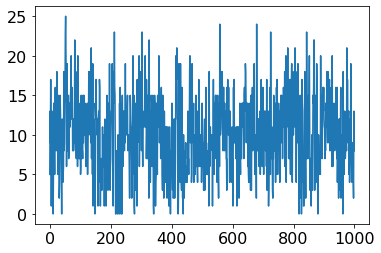

In [110]:
plt.plot(np.sum(sam,1)[:1000])

Text(0, 0.5, 'k real')

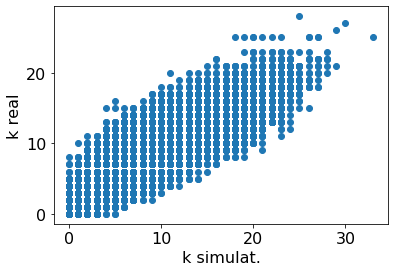

In [114]:
plt.scatter(np.sum(sam,1), nk)
plt.xlabel('k simulat.')
plt.ylabel('k real')